In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd
import numpy as np
import csv
from os import listdir
from os.path import isfile, join
import skfda
from skfda.representation.interpolation import SplineInterpolation
from skfda.exploratory.visualization import Boxplot
from numpy.polynomial.polynomial import polyfit
from random import *
from scipy.signal import argrelextrema

In [2]:
# Variabili globali

path = 'pala_5/24-05-2023/'

In [3]:
allNI = []
allRPM = []
all_Volts = []

# Andiamo a prendere tutti i path dei vari file

path_acquisizioni = [f for f in listdir(path) if isfile(join(path, f))]

Text(0, 0.5, 'National instrument')

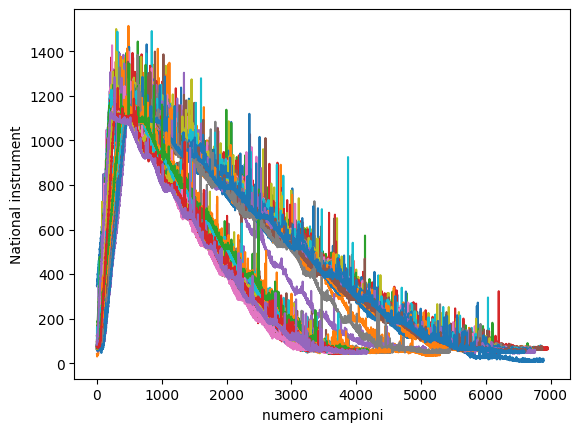

In [4]:
NiPrefix = 'measure_NI'
VoltsPrefix = 'measure_Volts'
RpMPrefix = 'measure_RPM'

for a in range(int(len(path_acquisizioni)/3)):
    allRPM.append(pd.read_csv(path+RpMPrefix+str(a)+'.csv',sep='\t').drop_duplicates(subset=['time'],keep='last',ignore_index=True))
    all_Volts.append(pd.read_csv(path+VoltsPrefix+str(a)+'.csv',sep='\t').drop_duplicates(subset=['time'],keep='last',ignore_index=True))
    try:
        allNI.append(pd.read_csv(path+NiPrefix+str(a)+'.csv',sep='\t').drop_duplicates(subset=['time'],keep='last',ignore_index=True))
    except:
        df = pd.read_csv(path+NiPrefix+str(a)+'.csv',sep='\t').drop_duplicates(subset=['Time'],keep='last',ignore_index=True)
        allNI.append(df.rename(columns={"Time": "time"}))

        

allacqui = []
for a,b in zip(allNI,range(len(allNI))):
    allacqui.append([])
    a['Voltage'] = (10 - a['Voltage'])*500
    plt.plot(a['Voltage'])
    allacqui[-1].append(a)
plt.xlabel('numero campioni')
plt.ylabel('National instrument')

In [99]:
def data_augmentation(df:pd.DataFrame,dimension:int):

    difference = dimension-df.shape[0]
    random_value = np.random.randint(min(df.index.to_list())+1,max(df.index.to_list())-1,difference)
    def sampleValues(index):
        time = df.columns.values[0]
        value = df.columns.values[1]
        new_value = (df.loc[index][value]+df.loc[index+1][value])/2
        new_timestamp = df.loc[index][time] + 1000
        return {time:new_timestamp, value:new_value}

    
    df = pd.concat([df, pd.DataFrame(list(map(sampleValues,random_value)))]).sort_values('time').reset_index(drop=True)

    return df
        

In [100]:
max_list = []

for a in allNI:
    max_list.append(a.shape[0])

In [101]:
#get PWN from the RPM data.
from scipy.signal import argrelextrema
def getPWM(DataFrameRPM):
    #Get PWN of RPM/Battery
    DataFrameMean = DataFrameRPM['rpm'].rolling(50,min_periods = 1,center=False).mean()
    gradient = np.gradient(DataFrameMean,np.arange(DataFrameMean.shape[0]))+np.random.uniform(low=0.0, high=0.1, size=DataFrameMean.shape[0])
    gradientDataframe = pd.DataFrame(gradient)
    ilocs_min = argrelextrema(gradient, np.less_equal, order=100)[0]
    ilocs_max = argrelextrema(gradient, np.greater_equal, order=100)[0]
    Minindexes = gradientDataframe.iloc[ilocs_min].nsmallest(10,0, keep='first').index.sort_values()
    def genpwm(x):
        res = 100
        for i in Minindexes:
            if x>i:
                res = res-10
        return res
    ranges = DataFrameRPM.index
    maxindex = gradientDataframe.iloc[ilocs_max].nlargest(1,0, keep='first')
    pwmRPM = list(map(genpwm,list(ranges)))
    pwmRPM[:maxindex.index[0]] = [0] * (maxindex.index[0])
        
    return pwmRPM

c:\Users\pc\anaconda3\envs\manutenzione\lib\site-packages\pandas\plotting\_matplotlib\core.py:885: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  return ax.plot(*args, **kwds)


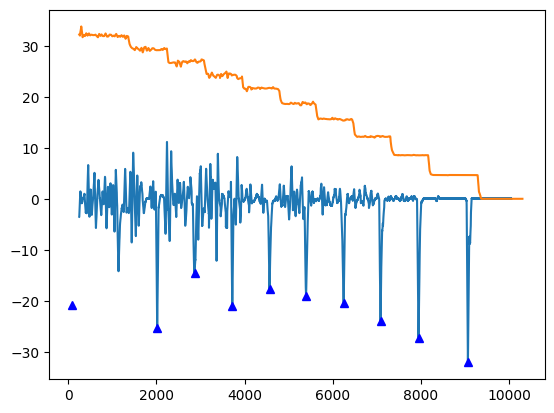

In [102]:


DataFrameMean = allRPM[0]['rpm'][250:].rolling(30,min_periods = 1,center=False).mean()

gradient = np.gradient(DataFrameMean,np.arange(DataFrameMean.shape[0]))+np.random.uniform(low=0.0, high=0.1, size=DataFrameMean.shape[0])
gradientDataframe = pd.DataFrame(gradient)

rollmax = np.array(pd.DataFrame(gradient).rolling(30,min_periods = 1,center=False).max())[:,0]
rollmaxDataframe = pd.DataFrame(gradient)

ilocs_min = argrelextrema(gradient, np.less_equal, order=100)[0]
ilocs_max = argrelextrema(gradient, np.greater_equal, order=100)[0]
Minindexes = gradientDataframe.iloc[ilocs_min].nsmallest(10,0, keep='first').index.sort_values()
fig, ax = plt.subplots(1, 1)
gradientDataframe[250:].plot(ax=ax,legend=False)
(allRPM[0]['rpm'][250:]/300).plot(ax=ax,legend=False)

gradientDataframe.iloc[Minindexes].plot(style='.', lw=10, color='blue', marker="^",ax=ax,legend=False);

<Axes: >

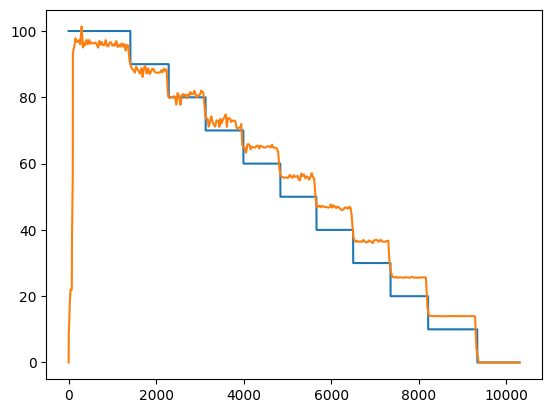

In [103]:
allPWM = [None] * len(allNI)
dim = max([len(allNI[0].index),len(allRPM[0].index),len(all_Volts[0].index)])

allPWM[0] = pd.DataFrame(getPWM(allRPM[0]),columns=['pwm'])
allPWM[0]['pwm'].plot()
(allRPM[0]['rpm']/100).plot()

In [104]:
allPWM = [None] * len(allNI)
pwm_min,pwm_max,pwm_offset = 1000,2000,1000
for ni,rpm,volt,indice in zip(allNI,allRPM,all_Volts,range(len(allNI))):
    dim = max([len(ni.index),len(rpm.index),len(volt.index)])

    allNI[indice] = data_augmentation(ni,dim).rolling(30,min_periods = 1,center=False).median()
    allRPM[indice] = data_augmentation(rpm,dim)
    all_Volts[indice] = data_augmentation(volt,dim)
    allPWM[indice] = pd.DataFrame(getPWM(allRPM[indice]),columns=['pwm'])

    cutIndex = allNI[indice].nlargest(1,'Voltage', keep='first').index[0]
    allPWM[indice] = allPWM[indice].iloc[cutIndex:]*pwm_offset/100+pwm_min
    all_Volts[indice] = all_Volts[indice].iloc[cutIndex:]
    allRPM[indice] = allRPM[indice].iloc[cutIndex:]
    allNI[indice] = allNI[indice].iloc[cutIndex:]

In [105]:
print(allNI[0])
maxindex = allNI[0].nlargest(1,'Voltage', keep='first').index[0]
print(maxindex)

               time      Voltage
462    1.685021e+15  1232.065140
463    1.685021e+15  1232.065140
464    1.685021e+15  1232.065140
465    1.685021e+15  1232.065140
466    1.685021e+15  1232.065140
...             ...          ...
10316  1.685022e+15    11.888654
10317  1.685022e+15    11.727111
10318  1.685022e+15    11.727111
10319  1.685022e+15    11.565568
10320  1.685022e+15    11.565568

[9859 rows x 2 columns]
462


<Axes: >

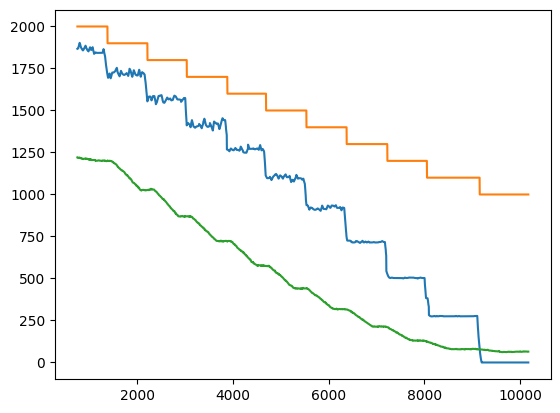

In [106]:
for a in range(len(allPWM)):
    allPWM[a].replace(to_replace=np.NaN, value=0,inplace = True)

for a in range(len(allRPM)):
    allRPM[a]['pwm'] = allPWM[a]

p = 10
(allRPM[p]['rpm']/5).plot()
allRPM[p]['pwm'].plot()
(allNI[p]['Voltage']).plot()

In [107]:
print(int((len(allNI)/4)-1))
idx = 0.25 * (len(allNI) - 1)
print(int(idx))
x = np.arange(8.0)
array = np.array(allNI,dtype='object')
print(array)

12
13
[               time      Voltage
 462    1.685021e+15  1232.065140
 463    1.685021e+15  1232.065140
 464    1.685021e+15  1232.065140
 465    1.685021e+15  1232.065140
 466    1.685021e+15  1232.065140
 ...             ...          ...
 10316  1.685022e+15    11.888654
 10317  1.685022e+15    11.727111
 10318  1.685022e+15    11.727111
 10319  1.685022e+15    11.565568
 10320  1.685022e+15    11.565568

 [9859 rows x 2 columns]                         time      Voltage
                                  832    1.685022e+15  1233.842116
                                  833    1.685022e+15  1233.438258
                                  834    1.685022e+15  1233.276715
                                  835    1.685022e+15  1233.276715
                                  836    1.685022e+15  1233.276715
                                  ...             ...          ...
                                  10267  1.685022e+15    37.775959
                                  10268  1.685022

In [108]:
all_NIquartile = []
all_RPMquartile = []
all_PWMquartile = []
ni_split = np.array_split(np.array(allNI,dtype='object'),4)
pwm_split = np.array_split(np.array(allPWM,dtype='object'),4)
rpm_split = np.array_split(np.array(allRPM,dtype='object'),4)


for indice in range(4):

    ni_array = []
    pwm_array = []
    rpm_array = []

    for indice_1 in range(len(ni_split[indice])):

        ni_array = np.append(ni_array,np.array(ni_split[indice][indice_1][ni_split[indice][indice_1].columns.values[1]]))
        pwm_array = np.append(pwm_array,np.array(pwm_split[indice][indice_1][pwm_split[indice][indice_1].columns.values[0]]))
        rpm_array = np.append(rpm_array,np.array(rpm_split[indice][indice_1][rpm_split[indice][indice_1].columns.values[1]]))

    all_NIquartile.append(pd.DataFrame(ni_array))
    all_RPMquartile.append(pd.DataFrame(rpm_array))
    all_PWMquartile.append(pd.DataFrame(pwm_array))
    
    

In [109]:
allNI = all_NIquartile
allPWM = all_PWMquartile
allRPM = all_RPMquartile

In [110]:
# Andiamo a definire un datagrid per ogni dataframe con NUOVE SPECIFICHE

all_data_grid = []
all_data_grid_pwm = []
for ni,rpm,pwm in zip(allNI,allRPM,allPWM):
        
    data_matrix = np.flip(np.array(ni[ni.columns.values[0]]))
    grid_points = np.flip(np.array(rpm[rpm.columns.values[0]]))

    all_data_grid.append(skfda.FDataGrid(
    data_matrix=data_matrix,
    grid_points=grid_points,
    dataset_name='Voltage - RPM',
    argument_names=(rpm.columns.values[0],),
    coordinate_names=(ni.columns.values[0],),
    interpolation=SplineInterpolation(interpolation_order=1)
    ))

    all_data_grid_pwm.append(skfda.FDataGrid(
    data_matrix=data_matrix,
    grid_points = np.flip(np.array(pwm[pwm.columns.values[0]])),
    dataset_name='Voltage - PWM',
    argument_names=(pwm.columns.values[0],),
    coordinate_names=(ni.columns.values[0],),
    interpolation=SplineInterpolation(interpolation_order=1)
    ))

In [111]:
all_data_grid[0]

FDataGrid(
    array([[[  65.31908139],
            [  65.15753815],
            [  65.15753815],
            ...,
            [1232.06514038],
            [1232.06514038],
            [1232.06514038]]]),
    grid_points=(array([   0.,    0.,    0., ..., 9701., 9695., 9689.]),),
    domain_range=((0.0, 9689.0),),
    dataset_name='Voltage - RPM',
    argument_names=(0,),
    coordinate_names=(0,),
    extrapolation=None,
    interpolation=SplineInterpolation(interpolation_order=1, monotone=False))

In [112]:
#Fitting for National Instrument
pol_maxGrade = 4
fit_result = []
fit_result_pwm = []
for i in range(pol_maxGrade):
    fit_result.append([])
    fit_result_pwm.append([])
    for j in range(len(all_data_grid)):
        fit_result[-1].append(polyfit(all_data_grid[j].grid_points[0],all_data_grid[j].data_matrix[0],deg=i+1))
        fit_result_pwm[-1].append(polyfit(all_data_grid_pwm[j].grid_points[0],all_data_grid_pwm[j].data_matrix[0],deg=i+1))

In [113]:
def makeColor(start:tuple = (1,0,0),end:tuple = (0,0,1),step:int = 46):
    if len(start)!=3 or len(end)!=3:
        raise Exception("not valid color")
    res = [None] * step
    for i in range(step):
        res[i] = (start[0]+(end[0] - start[0])*i/step,start[1]+(end[1] - start[1])*i/step,start[2]+(end[2] - start[2])*i/step,0.5)
    return res

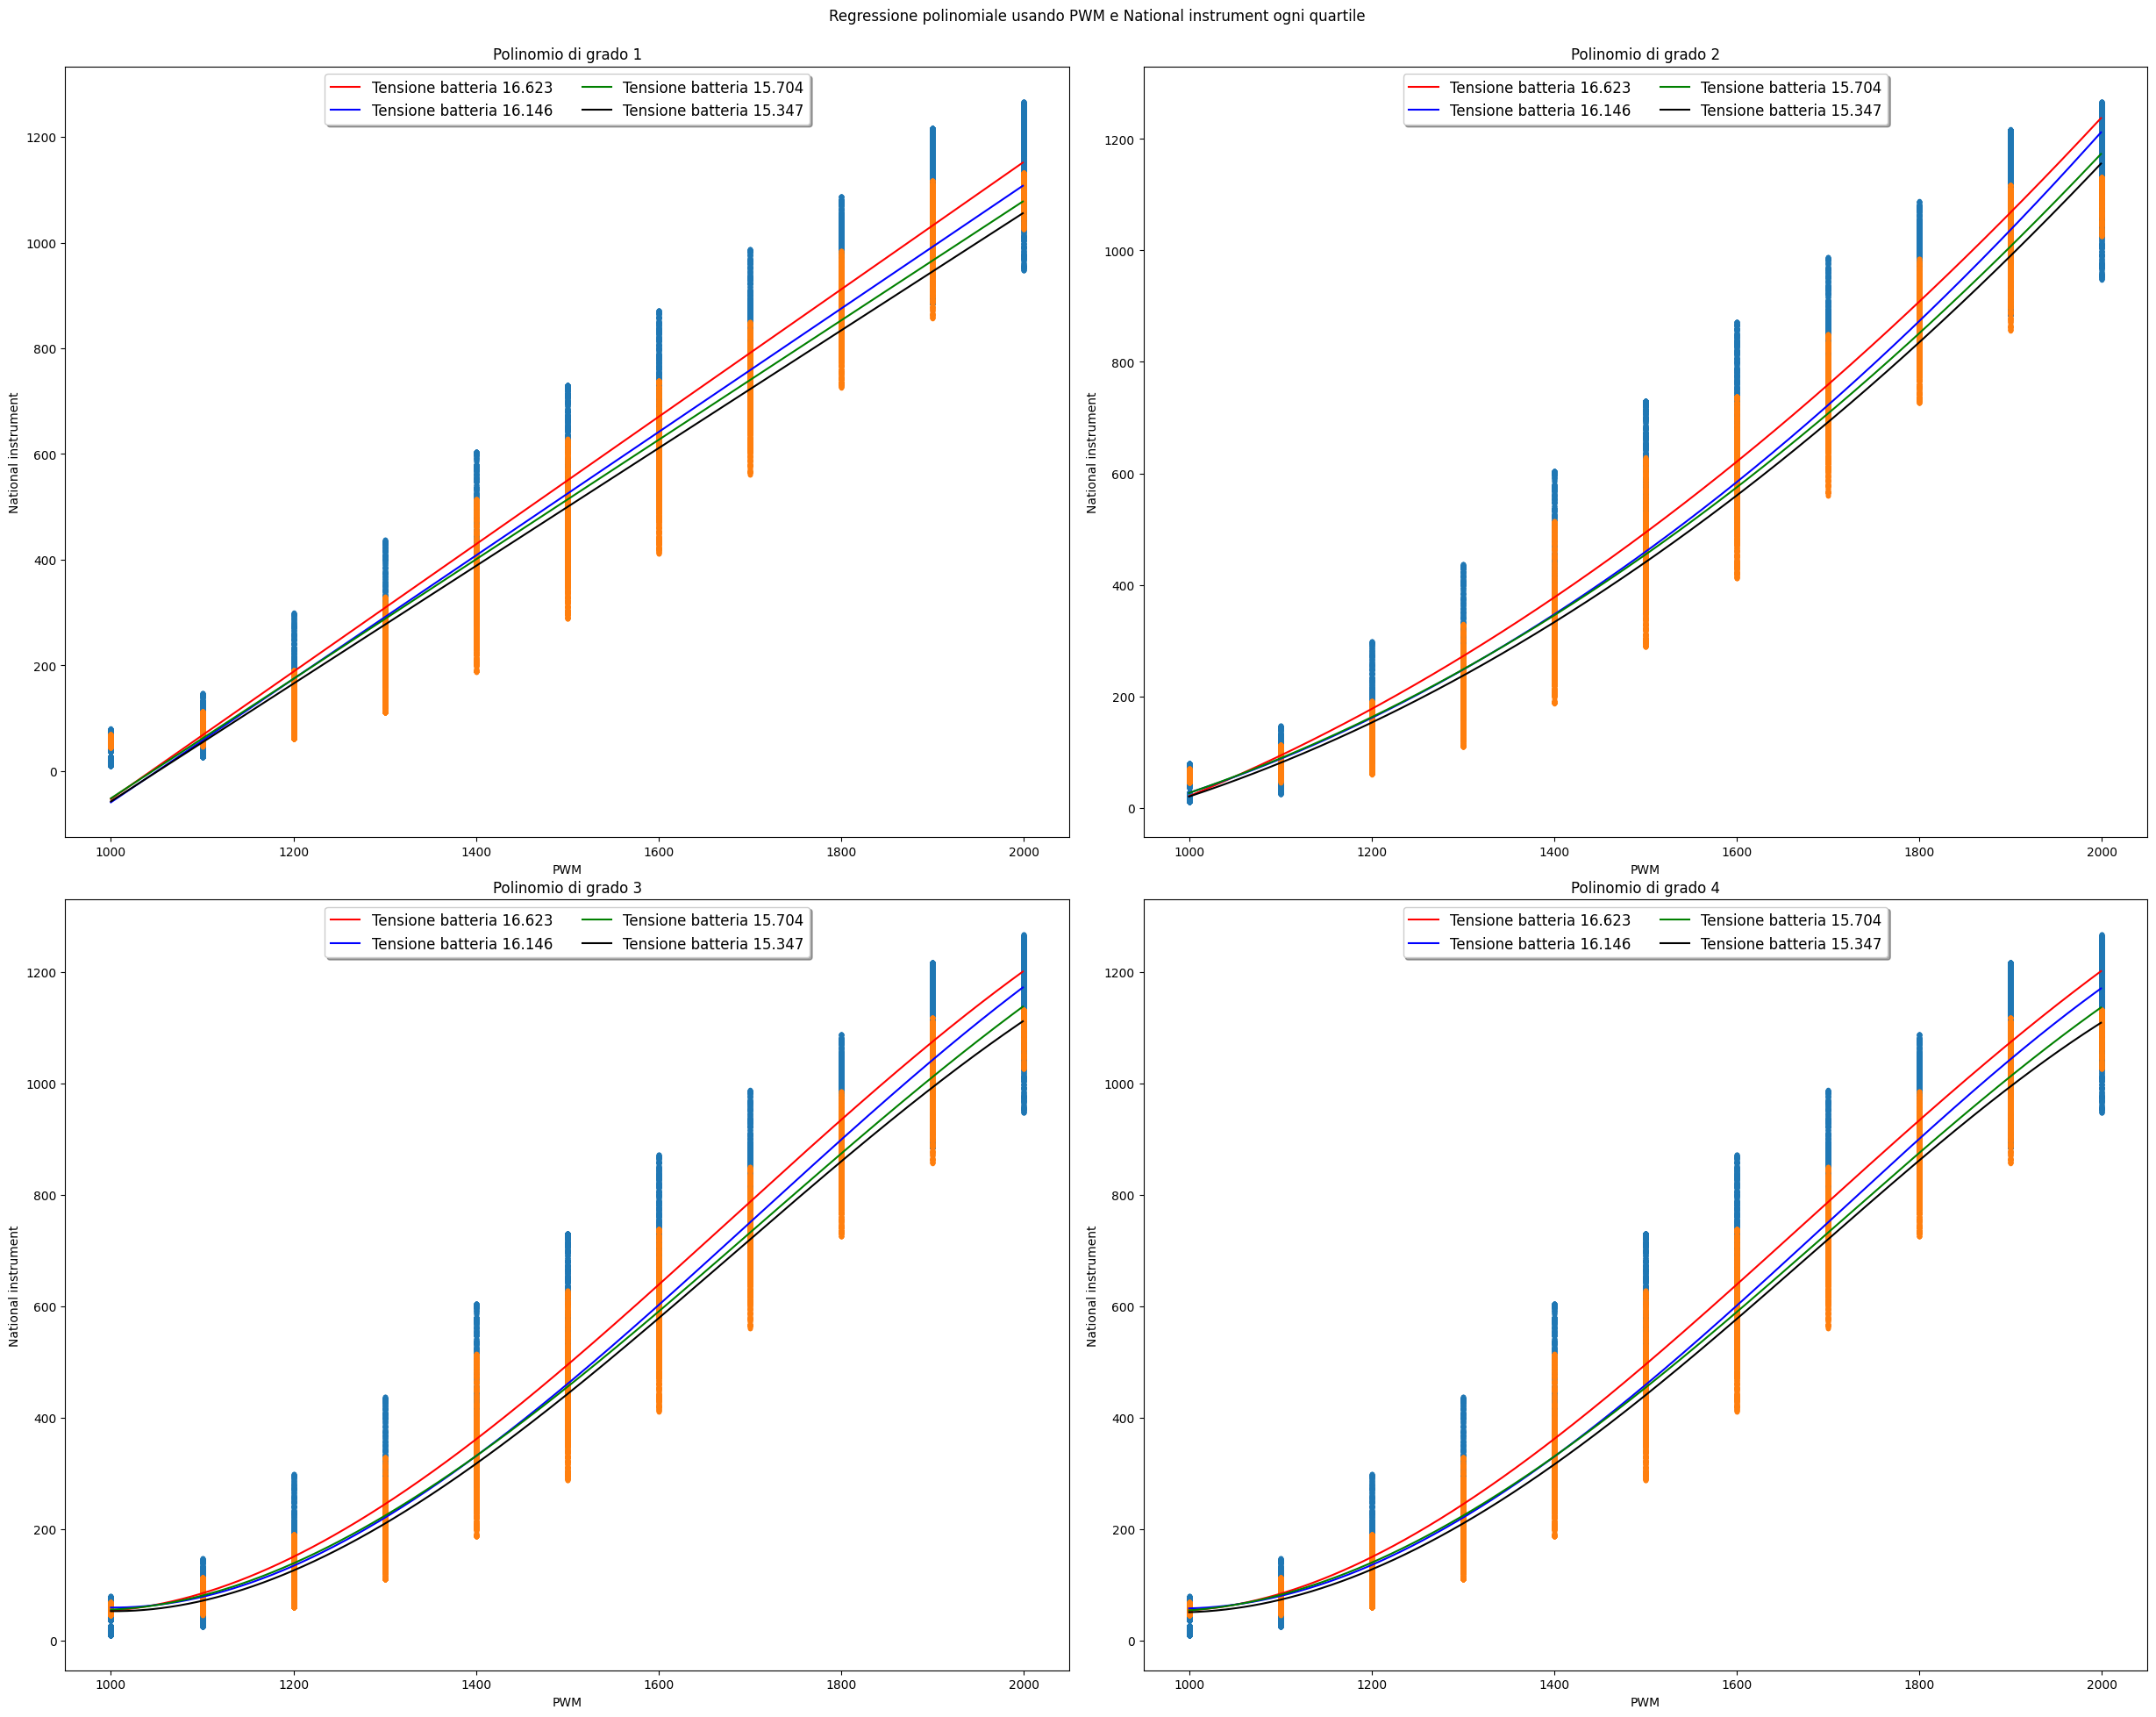

In [114]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)
fig.set_size_inches(h=20,w=25)
pwm_min,pwm_max = 1000,2000
colors = makeColor((1,0,0),(0,1,0),len(fit_result[0]))
inv_colors = makeColor((1,0,0),(0,1,0),len(fit_result[0]))
inv_colors.reverse()
linex = np.arange(pwm_min,pwm_max,1,dtype='longdouble')
fig.suptitle('Regressione polinomiale usando PWM e National instrument ogni quartile')
fig.tight_layout(pad=3)
volt_value = [all_Volts[0].iloc[-1]['volts'], all_Volts[15].iloc[-1]['volts'],all_Volts[30].iloc[-1]['volts'],all_Volts[45].iloc[-1]['volts']]
color = ['red','blue','green','black']
for grade_fit,grade,axs in zip(fit_result_pwm,range(pol_maxGrade),[ax1, ax2, ax3, ax4]):
        axs.plot(all_data_grid_pwm[0].grid_points[0],all_data_grid_pwm[0].data_matrix[0],'.')
        axs.plot(all_data_grid_pwm[len(all_data_grid_pwm)-1].grid_points[0],all_data_grid_pwm[len(all_data_grid_pwm)-1].data_matrix[0],'.')
        axs.set_xlabel('PWM')
        axs.set_ylabel('National instrument')
        axs.set_title('Polinomio di grado '+str(grade+1))
        cmap = LinearSegmentedColormap.from_list('my_list', inv_colors)
        
        
        for fit,index in zip(grade_fit,range(len(grade_fit))):
                plotRes = np.array([0]*(pwm_max-pwm_min),dtype='longdouble')
                for i in range(len(fit)):
                        plotRes += np.multiply(fit[i],np.power(linex,i))
                axs.plot(linex, plotRes,'-',label='Tensione batteria '+str(volt_value[index]),color=color[index])

        axs.legend(loc='upper center', bbox_to_anchor=(0.5, 1),ncol=2, fancybox=True, shadow=True,fontsize='large')